## Loading the Data

In [6]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
data_path = r'../data/raw/ab_test_click_data.csv'

df = pd.read_csv(data_path)

In [8]:
df.head(5)

,user_id,click,group,timestamp
0,1,1,exp,2024-01-01 00:00:00
1,2,0,exp,2024-01-01 00:01:00
2,3,1,exp,2024-01-01 00:02:00
3,4,0,exp,2024-01-01 00:03:00
4,5,1,exp,2024-01-01 00:04:00


In [9]:
df.shape

(20000, 4)

In [10]:
df.describe()

,user_id,click
count,20000.000000,20000.000000
mean,10000.500000,0.405250
std,5773.647028,0.490953
min,1.000000,0.000000
25%,5000.750000,0.000000
50%,10000.500000,0.000000
75%,15000.250000,1.000000
max,20000.000000,1.000000


In [11]:
df.groupby('group')['click'].sum()

group
con    1989
exp    6116
Name: click, dtype: int64

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   user_id    20000 non-null  int64 
 1   click      20000 non-null  int64 
 2   group      20000 non-null  object
 3   timestamp  10000 non-null  object
dtypes: int64(2), object(2)
memory usage: 625.1+ KB


A bar chart showing the total clicks verses no-clicks in each group

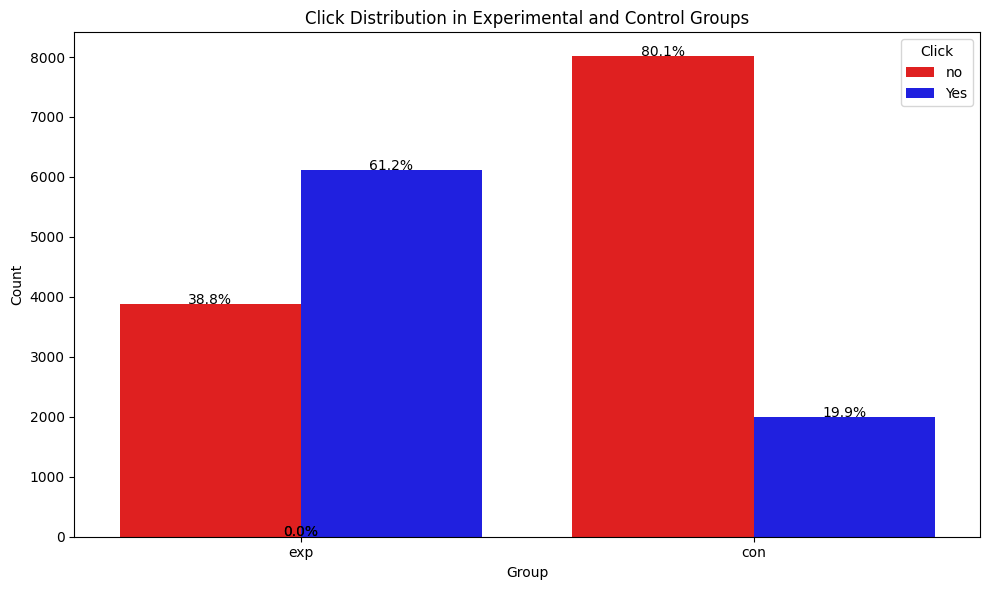

In [13]:
palette = {0: 'red', 1: 'blue'}

plt.figure(figsize=(10,6))
ax = sns.countplot(x='group', hue='click', data=df, palette=palette)
plt.title("Click Distribution in Experimental and Control Groups")
plt.xlabel('Group')
plt.ylabel('Count')
plt.legend(title="Click", labels=["no", "Yes"])

group_counts = df.groupby(['group']).size()
group_click_counts = df.groupby(['group','click']).size().reset_index(name="count")

for p in ax.patches:
    height = p.get_height()
    group = 'exp' if p.get_x() < 0.5 else 'con'
    click = 1 if p.get_x() % 1 > 0.5 else 0
    total = group_counts.loc[group]
    percentage = 100 * height / total
    ax.text(p.get_x() + p.get_width() / 2., height + 5, f'{percentage:.1f}%', ha="center", color='black', fontsize=10)

plt.tight_layout()
plt.show()

In [14]:
alpha = 0.05
print("Alpha: significant level is:", alpha)

delta = 0.1
print("Delta: minimum detectavble effect is:", delta)

Alpha: significant level is: 0.05
Delta: minimum detectavble effect is: 0.1


## Calculating total number of click for each group

In [34]:
N_con = df[df["group"] == "con"].count()["click"]
N_exp = df[df["group"] == "exp"].count()["click"]

X_con = df.groupby("group")["click"].sum().loc["con"]
X_exp = df.groupby("group")["click"].sum().loc["exp"]

print(df.groupby("group")["click"].sum())
print("Number of Users in control:", N_con)
print("Number of Users in Experimental:", N_exp)
print("Number of Clicks in control:", X_con)
print("Number of Clicks in Experimental:", X_exp)

group
con    1989
exp    6116
Name: click, dtype: int64
Number of Users in control: 10000
Number of Users in Experimental: 10000
Number of Clicks in control: 1989
Number of Clicks in Experimental: 6116


## Calculating Pooled Estimates for Clicks per Group

In [35]:
p_con_hat = X_con/N_con
p_exp_hat = X_exp/N_exp
print("Click Probability in Control Group:", p_con_hat)
print("Click Probability in Experimental Group:", p_exp_hat)

p_pooled_hat = (X_con+X_exp)/(N_con + N_exp)
print("Pooled Click Probability:", p_pooled_hat)

Click Probability in Control Group: 0.1989
Click Probability in Experimental Group: 0.6116
Pooled Click Probability: 0.40525


## Calculating Pooled Variance

In [36]:
pooled_variance = p_pooled_hat * (1-p_pooled_hat) * (1/N_con + 1/N_exp)
print("p^_pooled is:", p_pooled_hat)
print("pooled_variance is:", pooled_variance)

p^_pooled is: 0.40525
pooled_variance is: 4.82044875e-05


## Calculating Standard Error and Test Statistics

In [38]:
SE = np.sqrt(pooled_variance)
print("Standard Error is: ", SE)

Test_stat = (p_con_hat - p_exp_hat)/SE
Test_stat = Test_stat
print("Test Statistics for 2-sample Z-test is:", Test_stat)

Z_crit = norm.ppf(1-alpha/2)
print("Z-critical value from Standard Normal distribution: ", Z_crit)

Standard Error is:  0.006942945160376826
Test Statistics for 2-sample Z-test is: -59.44163326469381
Z-critical value from Standard Normal distribution:  1.959963984540054


## Calculating p_values of the Z_test

In [39]:
p_value = 2 * norm.sf(abs(Test_stat))

def is_statistical_significance(p_value, alpha):
    print(f"P-value of the 2-sample Z-test: {(p_value)}")

    if p_value <= alpha:
        print("There is statistical significance, indicating that the observed differences between the groups are unlikely to have occured by chance alone.")
    else:
        print("There is no statistical significance, suggesting that the observed differences between the groups could occured by chance.")

is_statistical_significance(p_value, alpha)

P-value of the 2-sample Z-test: 0.0
There is statistical significance, indicating that the observed differences between the groups are unlikely to have occured by chance alone.


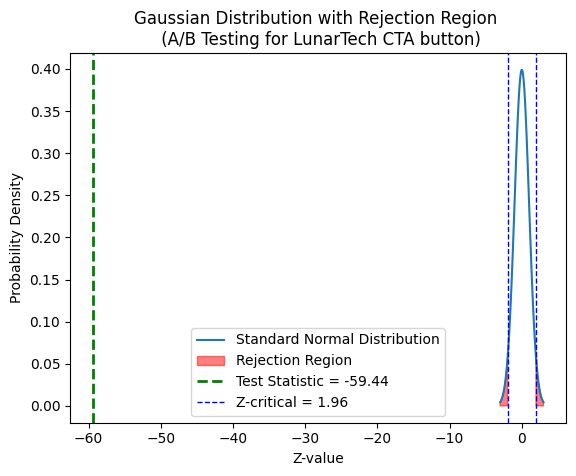

In [40]:
mu = 0
sigma = 1
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
y = norm.pdf(x, mu, sigma)

plt.plot(x, y, label='Standard Normal Distribution')
plt.fill_between(x, y, where=(x > Z_crit) | (x < -Z_crit), color='red', alpha=0.5, label='Rejection Region')
plt.axvline(Test_stat, color='green', linestyle='dashed', linewidth=2, label=f'Test Statistic = {Test_stat:.2f}')
plt.axvline(Z_crit, color='blue', linestyle='dashed', linewidth=1, label=f'Z-critical = {Z_crit:.2f}')
plt.axvline(-Z_crit, color='blue', linestyle='dashed', linewidth=1)

plt.xlabel('Z-value')
plt.ylabel('Probability Density')
plt.title('Gaussian Distribution with Rejection Region \n (A/B Testing for LunarTech CTA button)')
plt.legend()

plt.show()

## Calculating Confidence Interval of the test

In [42]:
CI = [
    round((p_exp_hat - p_con_hat) - SE*Z_crit, 3),
    round((p_exp_hat - p_con_hat) + SE*Z_crit, 3)
]

print("Confidence Interval of the 2 sample Z-test is: ", CI)

Confidence Interval of the 2 sample Z-test is:  [np.float64(0.399), np.float64(0.426)]


## Testing for Practical Significance in A/B Testing

In [48]:
def is_Practically_significant(delta, CI_95):
    lower_bound_CI = CI_95[0]

    if lower_bound_CI <= delta:
        print(f"We have pratical signifinace!")
        return True
    else:
        print("We dont have practical significant!")
        return False

delta = 0.05
CI_95 = (0.04, 0.06)
is_Practically_significant(delta, CI_95)

We have pratical signifinace!


True